In [1]:
import pandas as pd
import geopandas as gpd

import numpy as np

import os
import rasterio as rio ## we open rasterio as rio
from rasterio import features

from shapely.geometry import Polygon 
from pyproj import CRS

import matplotlib.pyplot as plt
%matplotlib inline


####  Open the clipped raster of house density of Cajamarca Region

In [35]:
def open_raster_rio(path_r):
    with rio.open(path_r) as dem1:
        band_1=dem1.read(1, masked=True)                ## We use the function read() to access the raster's values
        dem1_af=dem1.transform                          ## create a variable with the raster's affine values with the spatial georeferencing metadata
        return band_1, dem1_af

def open_shp(path_shp):                                ## is necessary to specify the minimun dataset columns (id	idccpp_17	pob_tot17	geometry)
    ccpp_x=gpd.read_file(path_shp)                     ## is efficient open the ccpp shp each time we call the final function?
    return ccpp_x
    
### Because of the large amount of  memory needed for converting the values to geometries, we must recode the raster's values as dummy values:
def recode_raster(density_val, band):
    band[band < density_val] = 0
    band[band >= density_val] = 1
    return band
    
def extract_coord(coor):
    p=coor.get('coordinates')  ## using the dictionary key named "coordinates", we call the coordinate's tuples
    poly=Polygon(p[0])         ## create a Polygon using the geometries from the areas extracted from the raster
    return poly

def extract_shapes(density_val_2, band_2, dem_af):
    data={'geometry':[]}
    
    band_2=recode_raster(density_val_2, band_2)
    mask_shp = band_2 == 1
    
    for geom, value in features.shapes(band_2, mask=mask_shp, transform=dem_af, connectivity=8):
        data['geometry'].append(extract_coord(geom))
    
    den_1=gpd.GeoDataFrame(data, geometry='geometry')
    den_1.crs = CRS.from_epsg(32718)
    return den_1

def high_density(path_tif, path_ccpp ,density_val_3, pob_min):
    ## Opening the raster and the shp with the ccpp geometries
    band_1, dem_af1=open_raster_rio(path_tif)
    ccpp_x=open_shp(path_ccpp)
    
    den_1=extract_shapes(density_val_3, band_1, dem_af1)
    
    ## make a spatial join
    pob_d1=den_1.sjoin(ccpp_x, how='right',predicate='intersects')

    pob_d1=pob_d1.dropna(subset=['index_left']).groupby('index_left').sum()
    pob_d1=pob_d1[pob_d1.pob_tot17>=pob_min].copy()

    den_1f=den_1.merge(pob_d1, left_index=True, right_index=True, how='inner')
    return den_1f

In [42]:
## Define the general path
path_d=r"C:\Users\Guillermo\Desktop/Python/01. Raster/01. Database"

## define data of Cajamarca's ccpp
ccpp_06=(path_d+"\\caja_ccpp_edit.shp")
### we define the right path
path_density=(path_d+"\\caja_dv_clip.tif")

## Open the GEOtif file using rasterio
a=high_density(path_density,ccpp_06, 0.78, 1)
b=high_density(path_density,ccpp_06,2 , 10000)
c=high_density(path_density,ccpp_06,7 , 25000)


<AxesSubplot:>

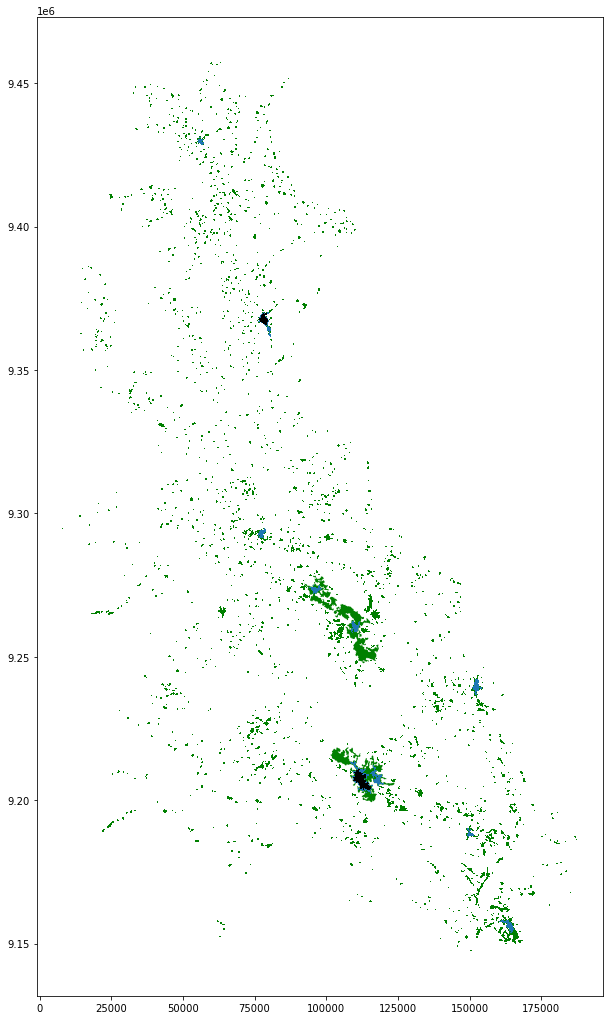

In [43]:
fig, ax=plt.subplots(figsize=(18,18))

a.plot(ax=ax, facecolor='green')
b.plot(ax=ax)
c.plot(ax=ax,facecolor='black')

In [ ]:
# import pprint
# pprint.pprint(next(shapes))

In [ ]:


https://gis.stackexchange.com/questions/92176/gdal-polygonize-in-python-creating-blank-polygon


https://hatarilabs.com/ih-en/how-to-convert-a-raster-to-contours-with-python-and-gdal-tutorial

https://gis.stackexchange.com/questions/268331/how-can-i-extract-contours-from-a-raster-with-python